In [4]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [5]:
! gunzip GSE123813_bcc_scRNA_counts.txt.gz
adata = (sc.read_csv("GSE123813_bcc_scRNA_counts.txt", first_column_names=True, delimiter ="\t"))

gzip: GSE123813_bcc_scRNA_counts.txt.gz: No such file or directory


In [6]:
adata = adata.transpose()

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [16]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt","ribo", "hb"], inplace=True, log1p=True, percent_top=None
)

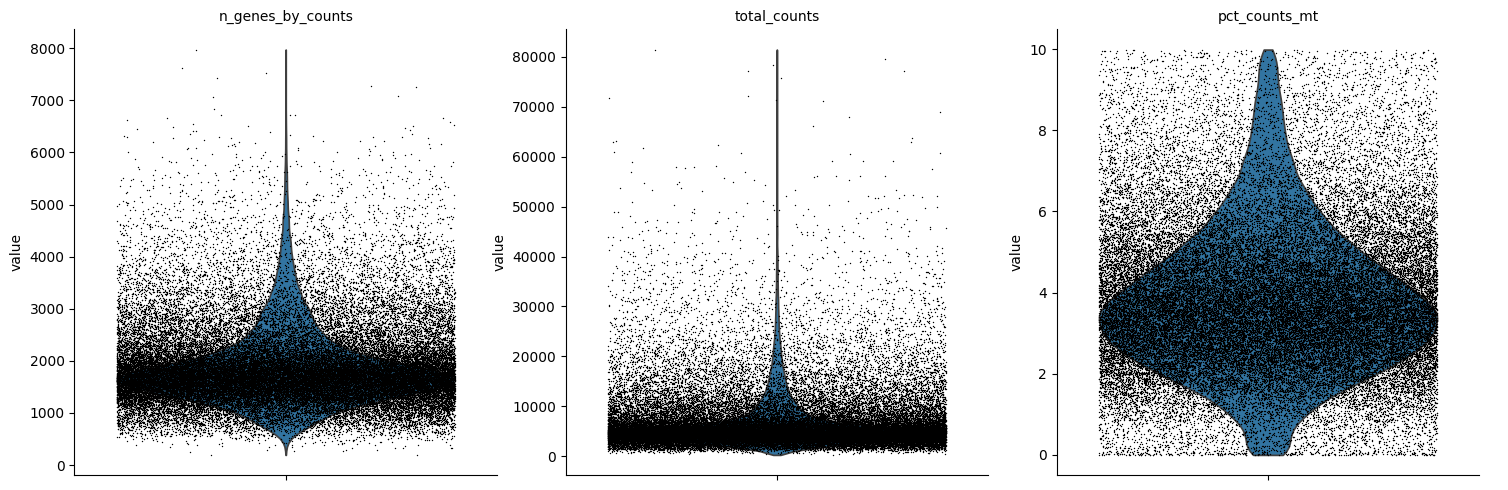

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

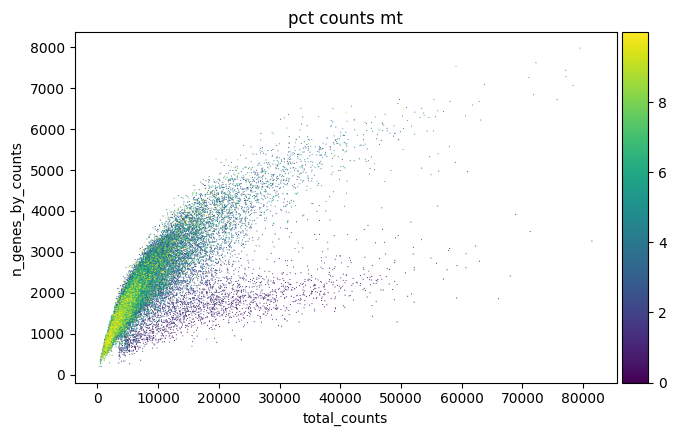

In [17]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [18]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [19]:
adata.layers["counts"] = adata.X.copy()

In [20]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

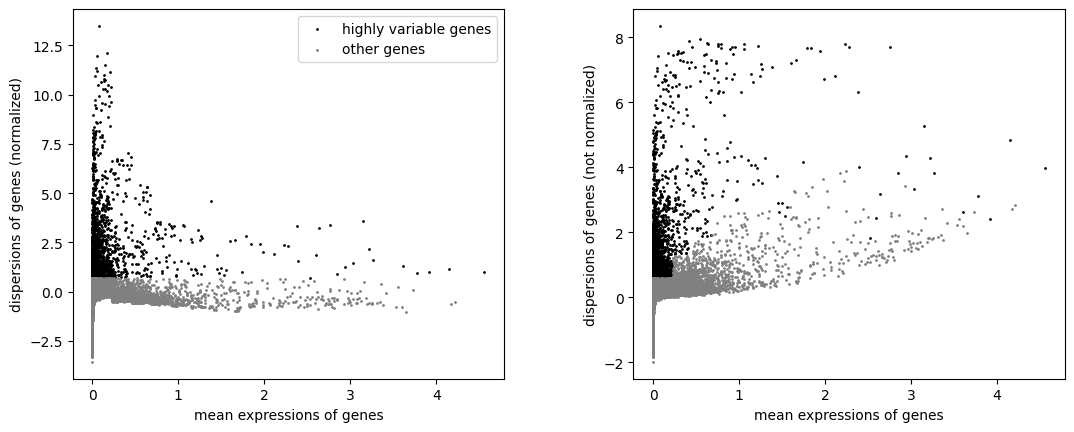

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
sc.tl.pca(adata)

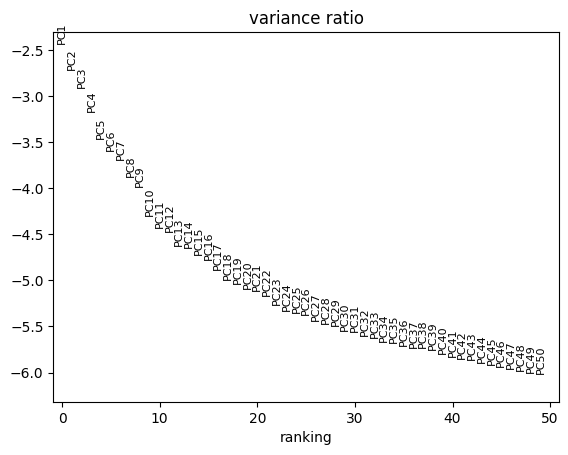

In [25]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

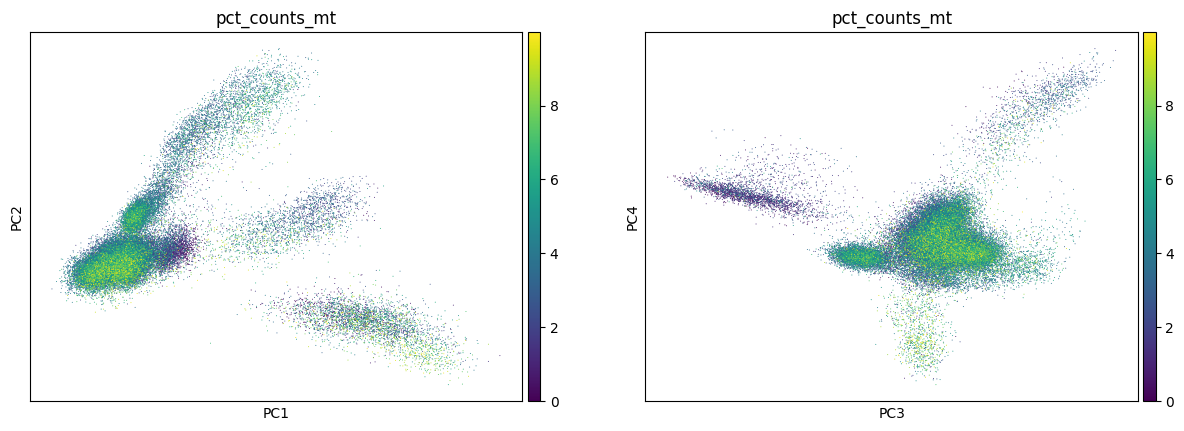

In [26]:
sc.pl.pca(
    adata,
    color=["pct_counts_mt", "pct_counts_mt"],
    dimensions=[ (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [27]:
sc.pp.neighbors(adata)

2024-08-06 21:18:24.238913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 21:18:25.810161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [28]:
sc.tl.umap(adata)

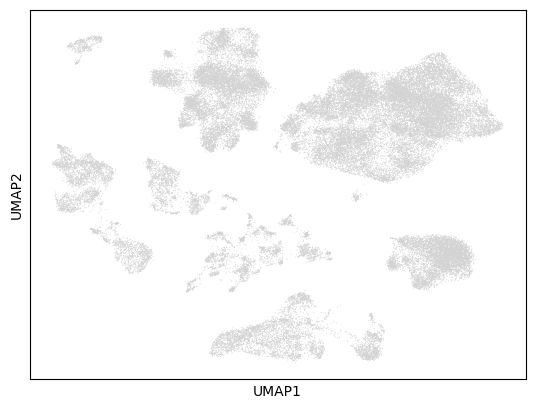

In [29]:
sc.pl.umap(
    adata,
    
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [30]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

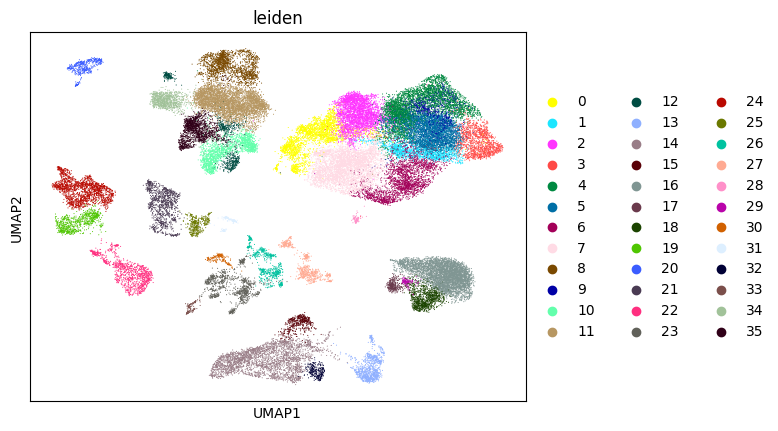

In [31]:
sc.pl.umap(adata, color=["leiden"])

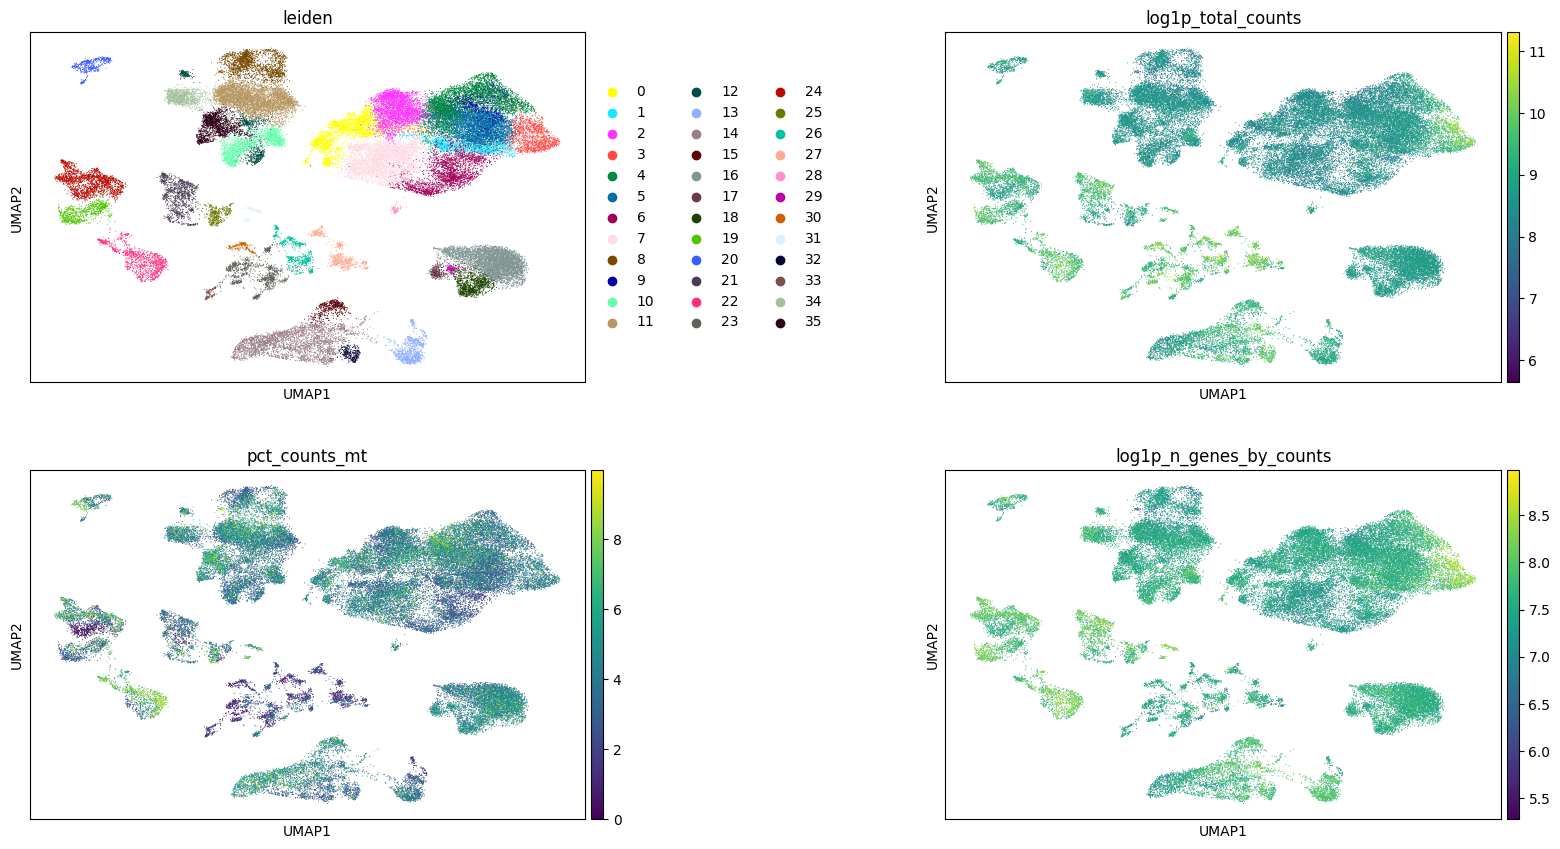

In [32]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

In [36]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

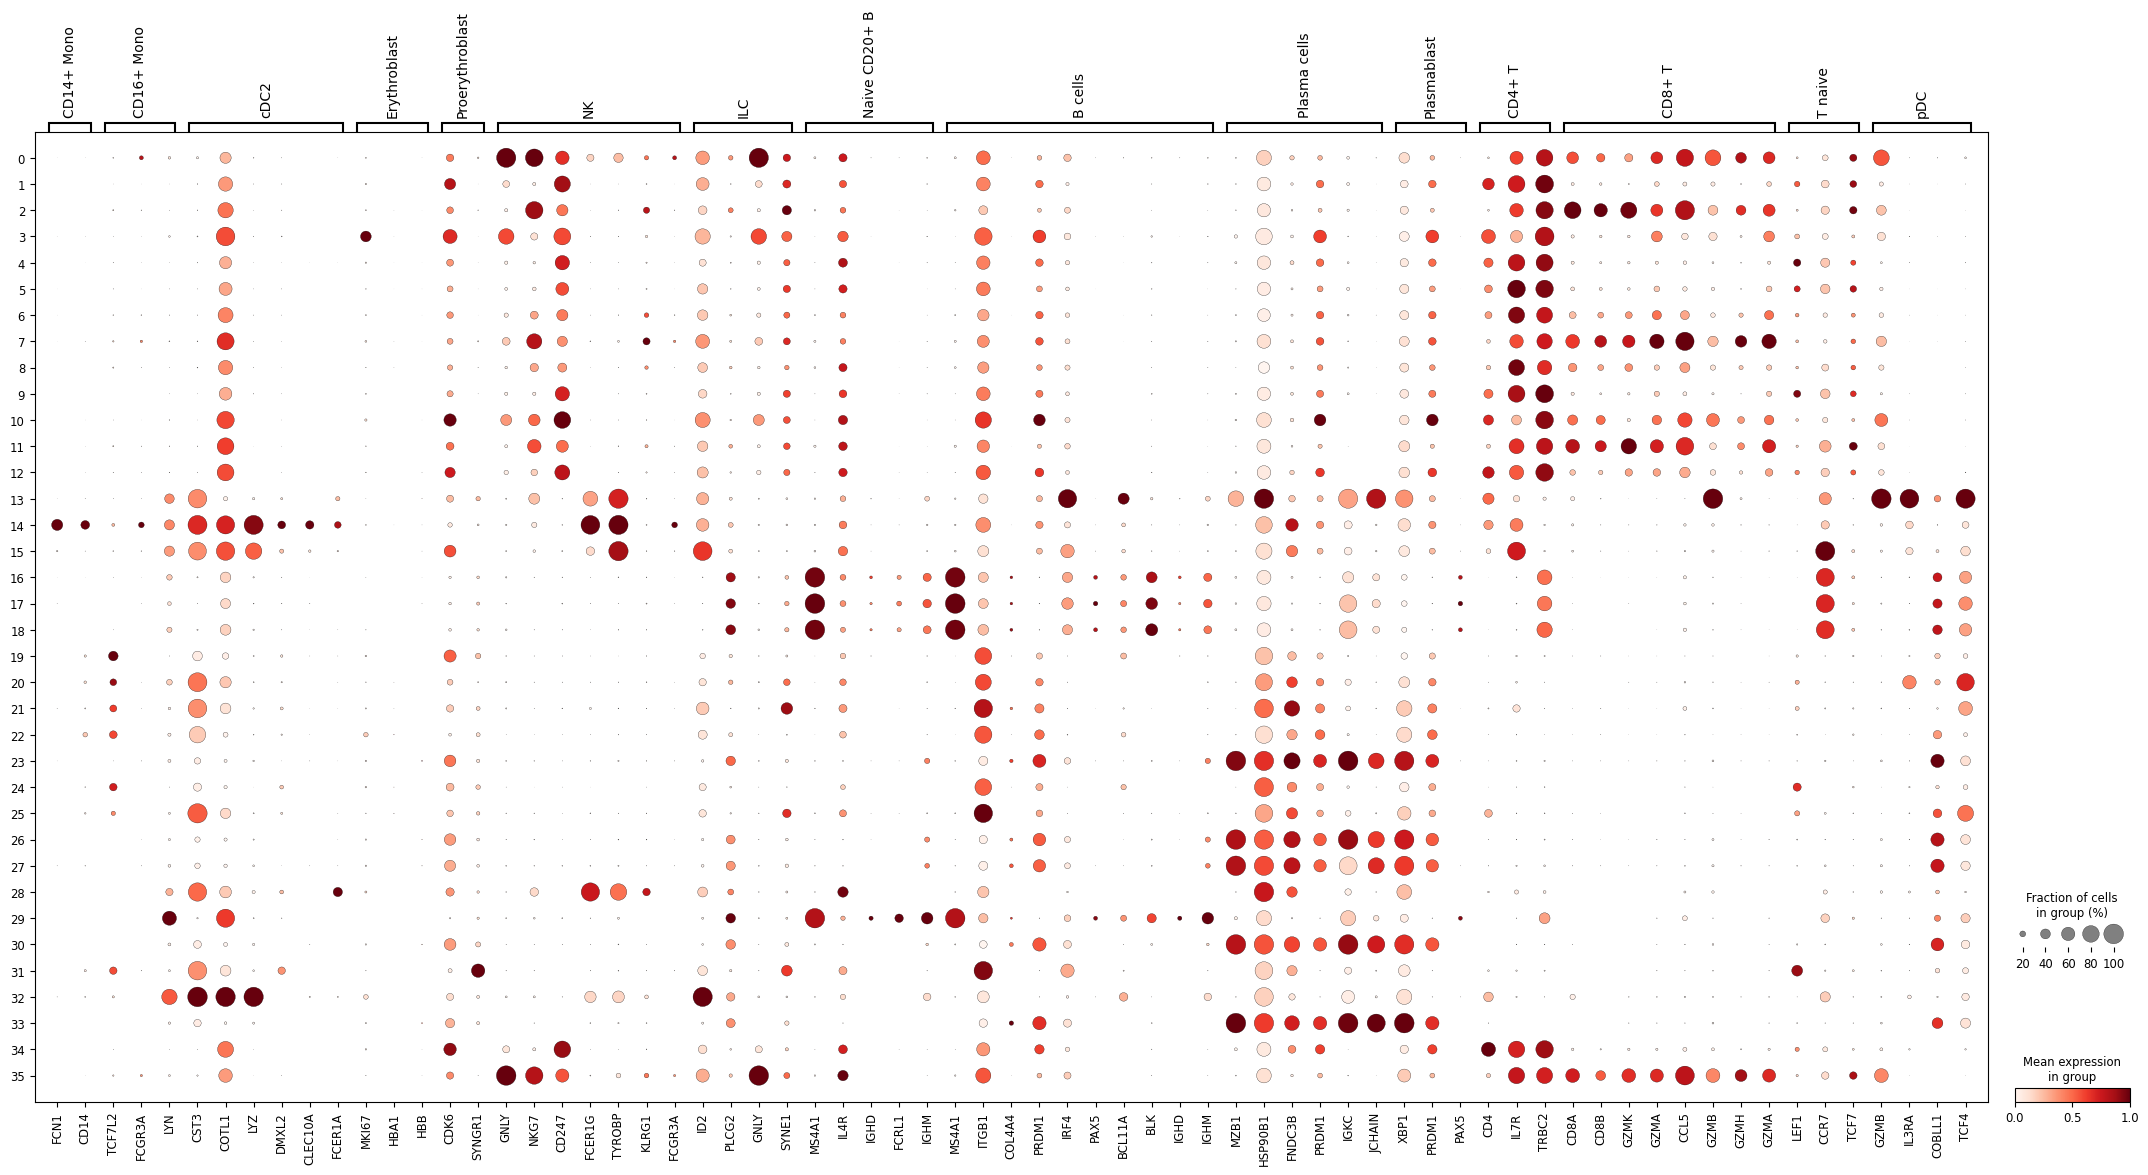

In [37]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden", standard_scale="var")

In [38]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/jupyterhub/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  This is usu

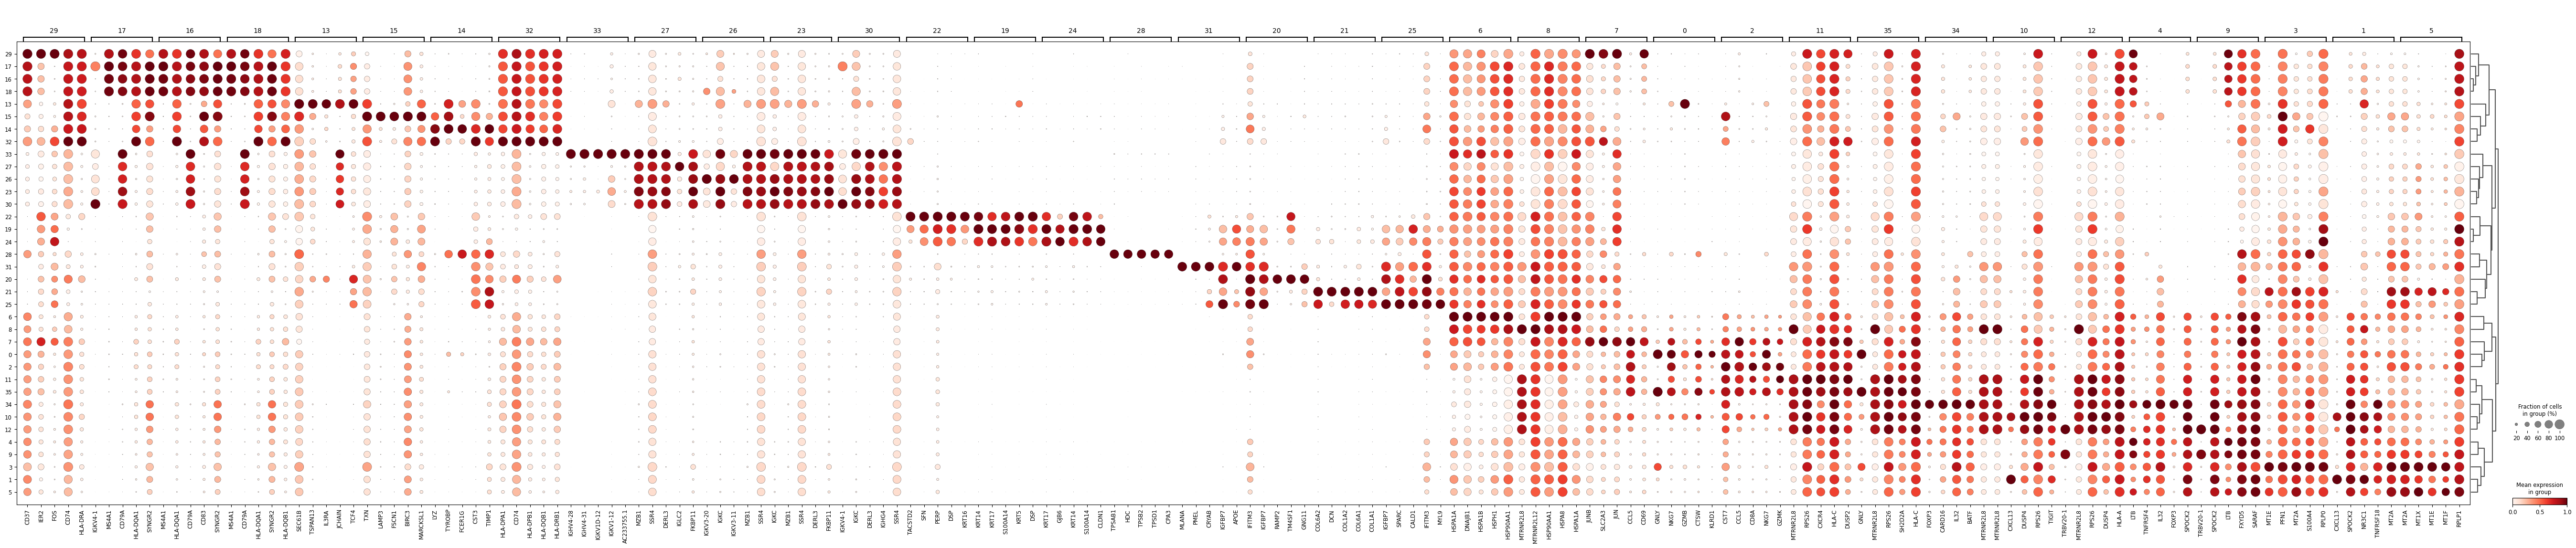

In [39]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

In [42]:
sc.get.rank_genes_groups_df(adata, group="19").head(5)

names     scores  logfoldchanges  pvals  pvals_adj
0    KRT14  45.734440        7.515798    0.0        0.0
1    KRT17  45.597134        8.040080    0.0        0.0
2  S100A14  45.045059        5.960873    0.0        0.0
3     KRT5  44.955566        6.292927    0.0        0.0
4      DSP  44.401962        5.418178    0.0        0.0

In [1]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="19").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
    color_map = "viridis"
)

NameError: name 'sc' is not defined

In [45]:
a_df  = adata.to_df(layer="counts")

In [47]:
a_df

FO538757.2  AP006222.2  RP11-206L10.9  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA          0.0         0.0            0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG          0.0         0.0            0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC          0.0         0.0            0.0   
bcc.su001.pre.tcell_AAACGGGTCATACGGT          0.0         0.0            0.0   
bcc.su001.pre.tcell_AAACGGGTCATAGCAC          0.0         0.0            0.0   
...                                           ...         ...            ...   
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT         0.0         0.0            0.0   
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA         0.0         0.0            0.0   
bcc.su012.post.tcell_TTTGTCAAGCACCGTC         0.0         0.0            0.0   
bcc.su012.post.tcell_TTTGTCAAGTGAACGC         0.0         0.0            0.0   
bcc.su012.post.tcell_TTTGTCAGTCCCTTGT         0.0         0.0            0.0   

                                       LINC00115  FAM41C  NOC2L  KLHL17  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA         1.0     0.0    0.0     0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG         0.0     0.0    0.0     0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC         0.0     0.0    0.0     0.0   
bcc.su001.pre.tcell_AAACGGGTCATACGGT         0.0     0.0    0.0     0.0   
bcc.su001.pre.tcell_AAACGGGTCATAGCAC         0.0     0.0    0.0     0.0   
...                                          ...     ...    ...     ...   
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT        1.0     0.0    0.0     0.0   
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA        0.0     0.0    0.0     0.0   
bcc.su012.post.tcell_TTTGTCAAGCACCGTC        0.0     0.0    0.0     0.0   
bcc.su012.post.tcell_TTTGTCAAGTGAACGC        0.0     0.0    0.0     0.0   
bcc.su012.post.tcell_TTTGTCAGTCCCTTGT        0.0     0.0    0.0     0.0   

                                       PLEKHN1  HES4  ISG15  ...  THRIL  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA       0.0   0.0    2.0  ...    0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG       0.0   0.0    0.0  ...    0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC       0.0   0.0    0.0  ...    0.0   
bcc.su001.pre.tcell_AAACGGGTCATACGGT       0.0   0.0    0.0  ...    0.0   
bcc.su001.pre.tcell_AAACGGGTCATAGCAC       0.0   0.0    0.0  ...    0.0   
...                                        ...   ...    ...  ...    ...   
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT      0.0   0.0    0.0  ...    0.0   
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA      0.0   0.0    0.0  ...    0.0   
bcc.su012.post.tcell_TTTGTCAAGCACCGTC      0.0   0.0    0.0  ...    0.0   
bcc.su012.post.tcell_TTTGTCAAGTGAACGC      0.0   0.0    0.0  ...    0.0   
bcc.su012.post.tcell_TTTGTCAGTCCCTTGT      0.0   0.0    0.0  ...    0.0   

                                       IGHV3-29  RP11-715J22.4  CTA-363E6.7  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA        0.0            0.0          0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG        0.0            0.0          0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC        0.0            0.0          0.0   
bcc.su001.pre.tcell_AAACGGGTCATACGGT        0.0            0.0          0.0   
bcc.su001.pre.tcell_AAACGGGTCATAGCAC        0.0            0.0          0.0   
...                                         ...            ...          ...   
bcc.su012.post.tcell_TTTGCGCGTCTTTCAT       0.0            0.0          0.0   
bcc.su012.post.tcell_TTTGGTTCAGCCAGAA       0.0            0.0          0.0   
bcc.su012.post.tcell_TTTGTCAAGCACCGTC       0.0            0.0          0.0   
bcc.su012.post.tcell_TTTGTCAAGTGAACGC       0.0            0.0          0.0   
bcc.su012.post.tcell_TTTGTCAGTCCCTTGT       0.0            0.0          0.0   

                                       RP11-538I12.2  RP11-314A20.5  FNDC8  \
bcc.su001.pre.tcell_AAACCTGCAGATCGGA             0.0            0.0    0.0   
bcc.su001.pre.tcell_AAACCTGCAGGGATTG             0.0            0.0    0.0   
bcc.su001.pre.tcell_AAACGGGCATAGACTC             0.0            0.0    0.0   
bcc.su001.pre.t

In [7]:
import pandas as pd
cell_meta = pd.read_csv("pre_post__tcrs_clinical_GSE123813_bcc_all_metadata (3).txt", delimiter="\t", index_col=0)

/tmp/ipykernel_3316268/2917952115.py:2: DtypeWarning: Columns (12,14,16,18,20,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_meta = pd.read_csv("pre_post__tcrs_clinical_GSE123813_bcc_all_metadata (3).txt", delimiter="\t", index_col=0)


In [8]:
cell_meta

patient treatment        sort  \
cell.id                                                               
bcc.su001.post.tcell_AAACCTGAGCTTCGCG   su001      post  CD45+ CD3+   
bcc.su001.post.tcell_AAACCTGAGGACATTA   su001      post  CD45+ CD3+   
bcc.su001.post.tcell_AAACCTGCACGCATCG   su001      post  CD45+ CD3+   
bcc.su001.post.tcell_AAACCTGCAGATGGGT   su001      post  CD45+ CD3+   
bcc.su001.post.tcell_AAACCTGCAGTGGAGT   su001      post  CD45+ CD3+   
...                                       ...       ...         ...   
bcc.su012.pre.tcell_TTTGGTTGTAGATTAG    su012       pre  CD45+ CD3+   
bcc.su012.pre.tcell_TTTGGTTGTCAAGCGA    su012       pre  CD45+ CD3+   
bcc.su012.pre.tcell_TTTGTCAAGAGGACGG    su012       pre  CD45+ CD3+   
bcc.su012.pre.tcell_TTTGTCACAATAGAGT    su012       pre  CD45+ CD3+   
bcc.su012.pre.tcell_TTTGTCAGTCACCCAG    su012       pre  CD45+ CD3+   

                                               cluster     UMAP1      UMAP2  \
cell.id                                                                       
bcc.su001.post.tcell_AAACCTGAGCTTCGCG  CD8_mem_T_cells -8.491220   5.533525   
bcc.su001.post.tcell_AAACCTGAGGACATTA   CD8_ex_T_cells  4.623724   6.668594   
bcc.su001.post.tcell_AAACCTGCACGCATCG  CD8_mem_T_cells -7.920441   3.196553   
bcc.su001.post.tcell_AAACCTGCAGATGGGT  CD8_mem_T_cells -7.878223   4.333302   
bcc.su001.post.tcell_AAACCTGCAGTGGAGT            Tregs -2.382094  11.260816   
...                                                ...       ...        ...   
bcc.su012.pre.tcell_TTTGGTTGTAGATTAG             Tregs  2.674866  11.652218   
bcc.su012.pre.tcell_TTTGGTTGTCAAGCGA   CD8_mem_T_cells -6.329399   5.186572   
bcc.su012.pre.tcell_TTTGTCAAGAGGACGG   CD8_mem_T_cells -8.817718   0.048990   
bcc.su012.pre.tcell_TTTGTCACAATAGAGT       CD4_T_cells  1.639496   7.203260   
bcc.su012.pre.tcell_TTTGTCAGTCACCCAG   CD8_mem_T_cells -8.385914   3.211823   

                                      Tumor Type      Treatment  \
cell.id                                                           
bcc.su001.post.tcell_AAACCTGAGCTTCGCG        BCC  Pembrolizumab   
bcc.su001.post.tcell_AAACCTGAGGACATTA        BCC  Pembrolizumab   
bcc.su001.post.tcell_AAACCTGCACGCATCG        BCC  Pembrolizumab   
bcc.su001.post.tcell_AAACCTGCAGATGGGT        BCC  Pembrolizumab   
bcc.su001.post.tcell_AAACCTGCAGTGGAGT        BCC  Pembrolizumab   
...                                          ...            ...   
bcc.su012.pre.tcell_TTTGGTTGTAGATTAG         BCC     Cemiplimab   
bcc.su012.pre.tcell_TTTGGTTGTCAAGCGA         BCC     Cemiplimab   
bcc.su012.pre.tcell_TTTGTCAAGAGGACGG         BCC     Cemiplimab   
bcc.su012.pre.tcell_TTTGTCACAATAGAGT         BCC     Cemiplimab   
bcc.su012.pre.tcell_TTTGTCAGTCACCCAG         BCC     Cemiplimab   

                                      Ongoing Vismodegib treatment  \
cell.id                                                              
bcc.su001.post.tcell_AAACCTGAGCTTCGCG                            +   
bcc.su001.post.tcell_AAACCTGAGGACATTA                            +   
bcc.su001.post.tcell_AAACCTGCACGCATCG                            +   
bcc.su001.post.tcell_AAACCTGCAGATGGGT                            +   
bcc.su001.post.tcell_AAACCTGCAGTGGAGT                            +   
...                                                            ...   
bcc.su012.pre.tcell_TTTGGTTGTAGATTAG                             -   
bcc.su012.pre.tcell_TTTGGTTGTCAAGCGA                             -   
bcc.su012.pre.tcell_TTTGTCAAGAGGACGG                             -   
bcc.su012.pre.tcell_TTTGTCACAATAGAGT                             -   
bcc.su012.pre.tcell_TTTGTCAGTCACCCAG                             -   

                                      Prior treatment  ...  \
cell.id                                                ...   
bcc.su001.post.tcell_AAACCTGAGCTTCGCG      Vismodegib  ...   
bcc.su001.post.tcell_AAACCTGAGGACATTA      Vismodegib  ...   
bcc.su001.post.tcell_AAACCTGCACGCATCG      Vismodegib  

In [11]:
adata2 = adata
adata2.obs = cell_meta

In [12]:
sc.pl.umap(
    adata2,
    color=["Response"],
    wspace=0.5,
    ncols=2,
)

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [18]:
obs_df = adata2.obs
pd.pivot_table(obs_df,  values = "cdr3s_aa", index = ("Response"), aggfunc="unique", columns = "Expansion_group", margins_name="Totals", margins=True, dropna=False, fill_value="NA", observed=False)

AttributeError: 'unique' is not a valid function for 'DataFrameGroupBy' object

In [16]:
pd.pivot_table(obs_df,  values = "patient", index = ("Response"), aggfunc="count", columns = "Pre_post_expansion_grp", margins_name="Totals", margins=True, dropna=False, fill_value="NA", observed=False)


Pre_post_expansion_grp  Contracted  Expanded  Lost  New  No change  Totals
Response                                                                  
No                             295       766   177  283         80   26149
Yes                            798      1323    25  357        653   26881
Totals                        1093      2089   202  640        733   53030